In [1]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

In [2]:
# 메모리 삭제
# torch.cuda.empty_cache()


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/opt/conda/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//10.88.0.1'

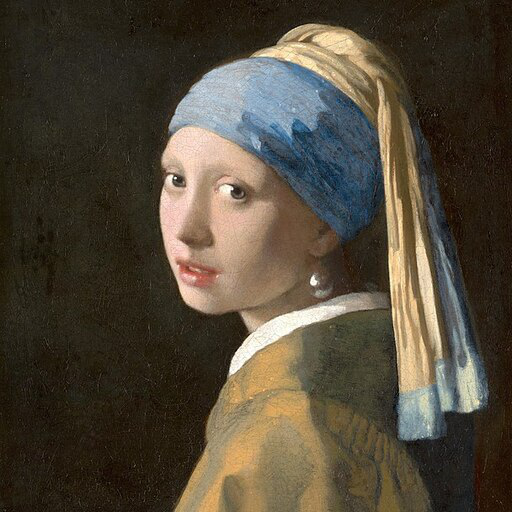

In [3]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image 

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

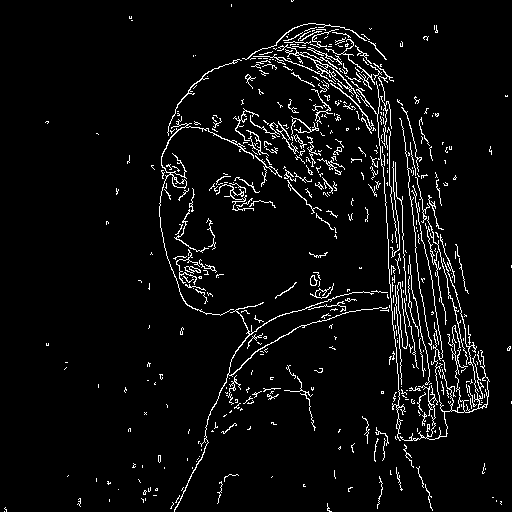

In [4]:
import cv2
from PIL import Image 
import numpy as np

# 이미지를 NumPy 배열로 변환합니다. 
image = np.array(image)

# threshold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다. 
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다. 

canny_image

In [5]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

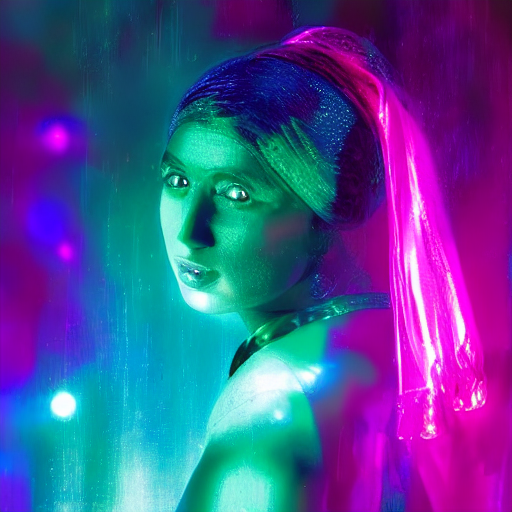

In [6]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

  0%|          | 0/30 [00:00<?, ?it/s]

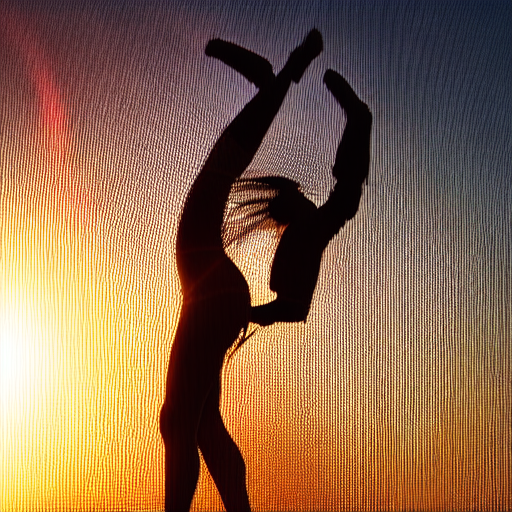

In [7]:
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요. 

generator = torch.manual_seed(256)

canny_image = canny_pipe(
    prompt="sports dancer under the sunlight", 
    num_inference_steps=30, 
    generator=generator, 
    image=canny_image
).images[0]

canny_image.save("/aiffel/aiffel/canny_image_2.png")  

canny_image

In [8]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

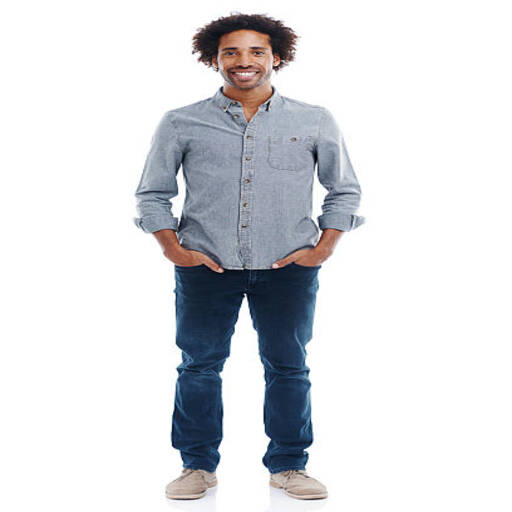

In [9]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

cuda


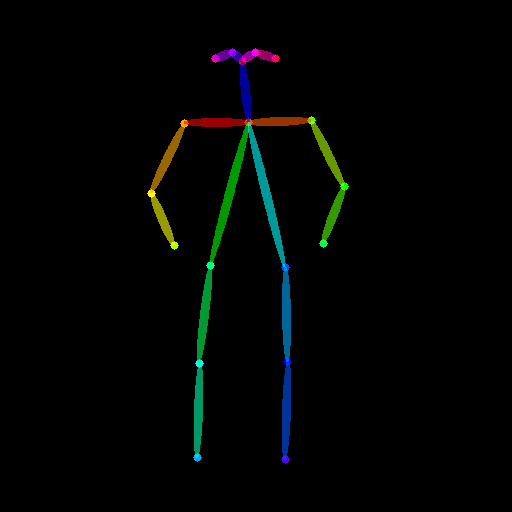

In [10]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [11]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel 

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

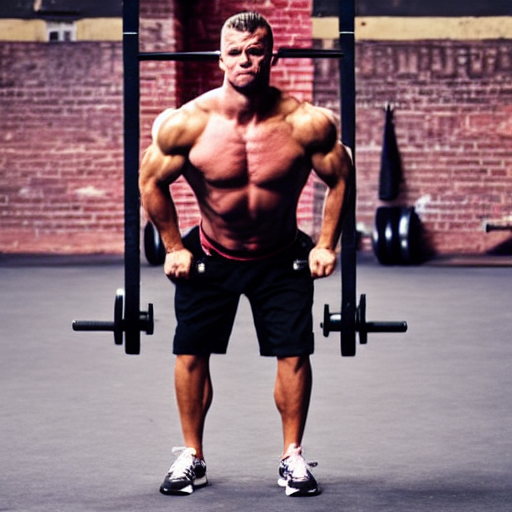

In [12]:
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다. 
generator = torch.manual_seed(1)

#프롬프트를 작성합니다. 
prompt =  "barbell squat on the mattress"
negative_prompt =  "thick mattress"

images = openpose_image

# 이미지를 생성합니다. 
openpose_image1 = openpose_pipe(prompt = prompt, negative_prompt = negative_prompt, num_inference_steps = 20, generator = generator, image = images).images[0]

# 생성된 이미지를 출력합니다. 
openpose_image1


  0%|          | 0/30 [00:00<?, ?it/s]

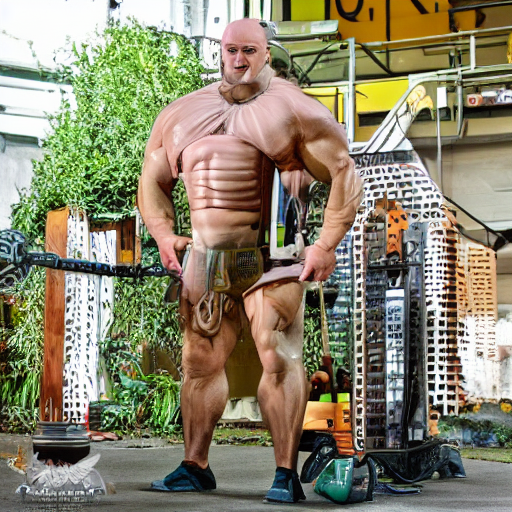

In [13]:
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요. 
prompt =  "muscle man is doing dips (weight training)"
negative_prompt =  "bald hair"

images = openpose_image

# 이미지를 생성합니다. 
openpose_image1 = openpose_pipe(prompt = prompt, negative_prompt = negative_prompt, num_inference_steps = 30, guidance_scale = 0.65, generator = generator, image = images).images[0]

# 생성된 이미지를 출력합니다. 
openpose_image1

In [14]:
from diffusers.utils import load_image 
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

# Q. 코드를 작성해 보세요.
# 이미지를 불러오세요. 
canny_image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
# canny_image = 

#threshhold를 지정합니다. 
low_threshold = 150
high_threshold = 220

# 이미지를 NumPy 배열로 변환합니다. 
canny_image = np.array(canny_image)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다. 
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다. 
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)
canny_image = canny_image[:,:,None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis = 2)

In [16]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image 

# Q. 아래의 코드를 작성해 주세요.
# 이미지를 불러옵니다. 
openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)

# OpenposeDetector를 사용하여 인체 자세를 검출합니다. 
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(openpose_image)

cuda


In [18]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  

# Q. 코드를 작성해 보세요.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다. 
controlnets = [canny_image, openpose_image]

# 리스트 controlnets를 파이프라인으로 전달합니다. 
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnets=controlnets, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# 프롬프트를 작성합니다. 
prompt =  "barbell squat on the mattress"
negative_prompt =  "bald hair"

# seed를 지정합니다. 
generator = torch.manual_seed(1)

images = [openpose_image, canny_image]

# 이미지를 생성합니다. 
image = pipe(image = images, prompt=prompt, negative_prompt = negative_prompt, num_inference_steps = 30, guidance_scale = 0.65, generator = generator).images[0]

# 생성된 이미지를 저장합니다.
image.save("aiffel/aiffel/multi_controlnet_output.png")

# 생성된 이미지를 출력합니다.  
image

OSError: runwayml/unipc-multistep-scheduler-v1 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login`.

In [ ]:
print("생성한 이미지를 올린 곳은 [[YOUR CODE]]입니다.")